## Paddy Disease Classification

**meta_train.csv** - The training set

- `image_id` - Unique image identifier corresponds to image file names (.jpg) found in the train_images directory.
- `label` - Type of paddy disease, also the target class. There are ten categories, including the normal leaf.
- `variety` - The name of the paddy variety.
- `age` - Age of the paddy in days.

**train_images** - This directory contains 10,407 training images stored under different sub-directories corresponding to ten target classes. Filename corresponds to the `image_id` column of `meta_train.csv`.

**test_images** - This directory contains 3,469 test set images.

In [ ]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model, layers, models, metrics

# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
model_name = 'clf-cnn'
dir_train_dataset = 'data/train/'
dir_test_dataset = 'data/test/'
dir_log = 'log/' + model_name
dir_models = 'models/'
path_model = dir_models + model_name


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.18.0
GPU is available


In [ ]:
!unzip "./data.zip" -d "./"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/downy_mildew/104000_af31de.jpg  
  inflating: /content/data/train/downy_mildew/104079_4de484.jpg  
  inflating: /content/data/train/downy_mildew/104079_720448.jpg  
  inflating: /content/data/train/downy_mildew/104079_7faa57.jpg  
  inflating: /content/data/train/downy_mildew/104098_19257f.jpg  
  inflating: /content/data/train/downy_mildew/104098_5203b3.jpg  
  inflating: /content/data/train/downy_mildew/104098_623ef3.jpg  
  inflating: /content/data/train/downy_mildew/104098_f2c45a.jpg  
  inflating: /content/data/train/downy_mildew/104100_ab0f58.jpg  
  inflating: /content/data/train/downy_mildew/104121_3238c0.jpg  
  inflating: /content/data/train/downy_mildew/104121_474e23.jpg  
  inflating: /content/data/train/downy_mildew/104121_89b96f.jpg  
  inflating: /content/data/train/downy_mildew/104121_b1f78c.jpg  
  inflating: /content/data/train/downy_mildew/104121_cdc647.jpg  
  inflating: /content/dat

In [3]:
def load(from_dir: str) -> pd.DataFrame:
    """
    Load a directory of paddy leaf disease images (e.g., data/train or data/test) into a DataFrame.

    Each subfolder is assumed to be a disease class label.

    Returns a DataFrame with:
    - image_path: Relative to from_dir
    - file_type: Extension
    - width, height: Image dimensions
    - ratio: width / height
    - mode: Image mode (e.g. RGB)
    - bands: Space-separated bands (e.g. "R G B")
    - transparency: Whether the image has an alpha channel
    - animated: Whether the image is an animated image (like GIF)
    - label: The disease class (from the folder name)
    """

    from_dir = Path(from_dir)
    data = {
        'image_path': [],
        'file_type': [],
        'width': [],
        'height': [],
        'ratio': [],
        'mode': [],
        'bands': [],
        'transparency': [],
        'animated': [],
        'label': []
    }

    for label_dir in from_dir.iterdir():
        if not label_dir.is_dir():
            continue

        for img_file in label_dir.iterdir():
            try:
                with Image.open(img_file) as im:
                    data['image_path'].append(str(img_file.relative_to(from_dir)))
                    data['file_type'].append(img_file.suffix.lstrip('.').lower())
                    data['width'].append(im.width)
                    data['height'].append(im.height)
                    data['ratio'].append(im.width / im.height)
                    data['mode'].append(im.mode)
                    data['bands'].append(' '.join(im.getbands()))
                    data['transparency'].append(
                        im.mode in ('RGBA', 'RGBa', 'LA', 'La', 'PA') or
                        (im.mode == 'P' and 'transparency' in im.info)
                    )
                    data['animated'].append(getattr(im, 'is_animated', False))
                    data['label'].append(label_dir.name)
            except Exception as e:
                print(f"Failed to process {img_file}: {e}")

    return pd.DataFrame(data)

In [4]:
df_train = load(dir_train_dataset)

In [5]:
df_train.head()

image_path file_type  width  height  ratio  \
0  bacterial_panicle_blight/108878_676a3a.jpg       jpg    256     256    1.0   
1  bacterial_panicle_blight/105118_eeec16.jpg       jpg    256     256    1.0   
2  bacterial_panicle_blight/105875_019f8e.jpg       jpg    256     256    1.0   
3  bacterial_panicle_blight/104678_62d0eb.jpg       jpg    256     256    1.0   
4  bacterial_panicle_blight/103733_126b28.jpg       jpg    256     256    1.0   

  mode  bands  transparency  animated                     label  
0  RGB  R G B         False     False  bacterial_panicle_blight  
1  RGB  R G B         False     False  bacterial_panicle_blight  
2  RGB  R G B         False     False  bacterial_panicle_blight  
3  RGB  R G B         False     False  bacterial_panicle_blight  
4  RGB  R G B         False     False  bacterial_panicle_blight

In [6]:
df_train.describe()

width   height    ratio
count  14112.0  14112.0  14112.0
mean     256.0    256.0      1.0
std        0.0      0.0      0.0
min      256.0    256.0      1.0
25%      256.0    256.0      1.0
50%      256.0    256.0      1.0
75%      256.0    256.0      1.0
max      256.0    256.0      1.0

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14112 entries, 0 to 14111
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_path    14112 non-null  object 
 1   file_type     14112 non-null  object 
 2   width         14112 non-null  int64  
 3   height        14112 non-null  int64  
 4   ratio         14112 non-null  float64
 5   mode          14112 non-null  object 
 6   bands         14112 non-null  object 
 7   transparency  14112 non-null  bool   
 8   animated      14112 non-null  bool   
 9   label         14112 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 909.7+ KB


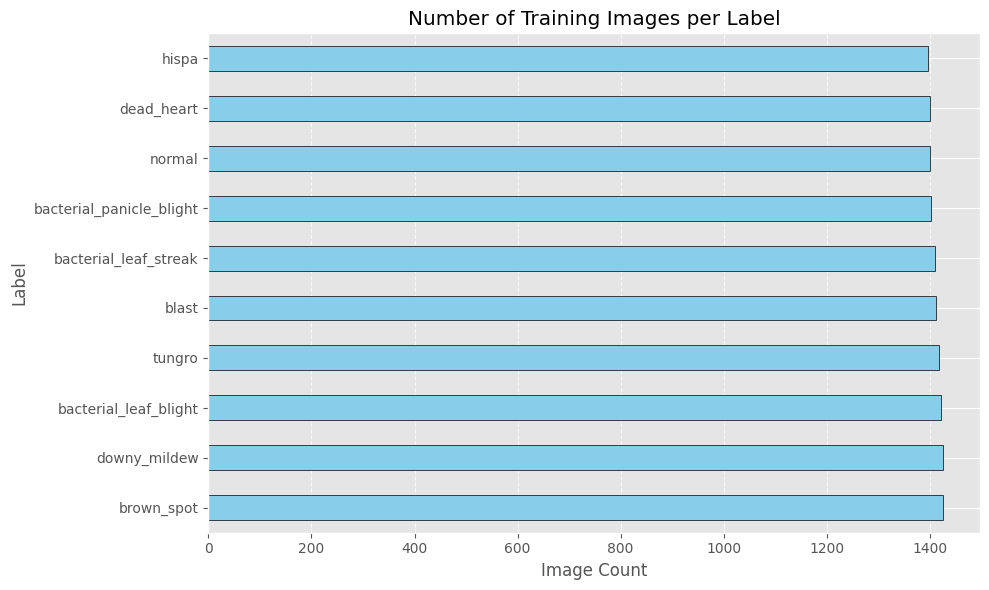

In [8]:
label_counts = df_train['label'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='barh', color='skyblue', edgecolor='black')

plt.title('Number of Training Images per Label')
plt.xlabel('Image Count')
plt.ylabel('Label')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
train, val = train_test_split(df_train, shuffle=True, test_size=0.2, random_state=42)  # 80/20/20 - train/val/test

print(f'Train data: {train.shape[0]} samples, Validation Data: {val.shape[0]} samples.')

Train data: 11289 samples, Validation Data: 2823 samples.


In [10]:
TARGET_IMG_SIZE = 256

In [11]:
# Model Parameters
BATCH_SIZE = 128
OUTPUT_CLASSES = 10  # One-hot encoded: 10 different classes

# Training Parameters
EPOCHS = 40
LEARNING_RATE = 0.0001
MOMENTUM = 0.9

In [ ]:
model = tf.keras.Sequential([
    layers.Flatten(input_shape=[256,256,3]),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(OUTPUT_CLASSES),
], name=model_name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy', metrics.Precision(name='precision'),
        metrics.Recall(name='recall')]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "clf-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,216,778 (96.19 MB)

 Trainable params: 25,216,778 (96.19 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
train['label'] = train['label'].astype('str')
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=dir_train_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val['label'] = val['label'].astype('str')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=dir_train_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 11289 validated image filenames belonging to 10 classes.
Found 2823 validated image filenames belonging to 10 classes.


In [16]:
batch = next(train_generator)
print(np.min(batch[0]), np.max(batch[0]))  # Should be around 0 to 1

0.0 1.0


In [17]:
print(batch[1][0])  # Print one label

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [18]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_log, write_graph=False)
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=EPOCHS, verbose=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/40
89/89 - 184s - 2s/step - categorical_accuracy: 0.0995 - loss: 2.4565 - precision: 0.0996 - recall: 0.1024 - val_categorical_accuracy: 0.1041 - val_loss: 2.3353 - val_precision: 0.1505 - val_recall: 0.0099
Epoch 2/40
89/89 - 178s - 2s/step - categorical_accuracy: 0.1129 - loss: 2.3251 - precision: 0.0638 - recall: 5.3149e-04 - val_categorical_accuracy: 0.1339 - val_loss: 2.3004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
89/89 - 179s - 2s/step - categorical_accuracy: 0.1380 - loss: 2.2980 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_categorical_accuracy: 0.1435 - val_loss: 2.2823 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
89/89 - 212s - 2s/step - categorical_accuracy: 0.1442 - loss: 2.2821 - precision: 0.5962 - recall: 0.0027 - val_categorical_accuracy: 0.1544 - val_loss: 2.2684 - val_precision: 0.6087 - val_recall: 0.0198
Epoch 5/40
89/89 - 178s - 2s/step - categorical_accuracy: 0.1579 - loss: 2.2694 - precision: 0.5489 - recall

In [ ]:
def plot_learning_curve(
    train_loss, val_loss, train_metric, val_metric, train_precision, val_precision, train_recall, val_recall,
    output_classes=10,
    to_file: str = None
) -> None:
    baseline = 1.0 / output_classes

    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    ax = ax.ravel()

    # Pack everything into a list to loop easily
    titles = ['Loss', 'Accuracy', 'Precision', 'Recall']
    ylabels = ['Loss', 'Accuracy', 'Precision', 'Recall']
    train_values = [train_loss, train_metric, train_precision, train_recall]
    val_values = [val_loss, val_metric, val_precision, val_recall]

    for i in range(4):
        ax[i].plot(train_values[i], 'r--', label='Train')
        ax[i].plot(val_values[i], 'b--', label='Val')
        if titles[i] == 'Accuracy':
            ax[i].axhline(y=baseline, c='g', linestyle='--', alpha=0.5, label='Random Baseline')
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(ylabels[i])
        ax[i].set_title(f"Training vs Validation {titles[i]}")
        ax[i].legend()

    fig.tight_layout()
    plt.show()

    if to_file:
        fig.savefig(to_file)

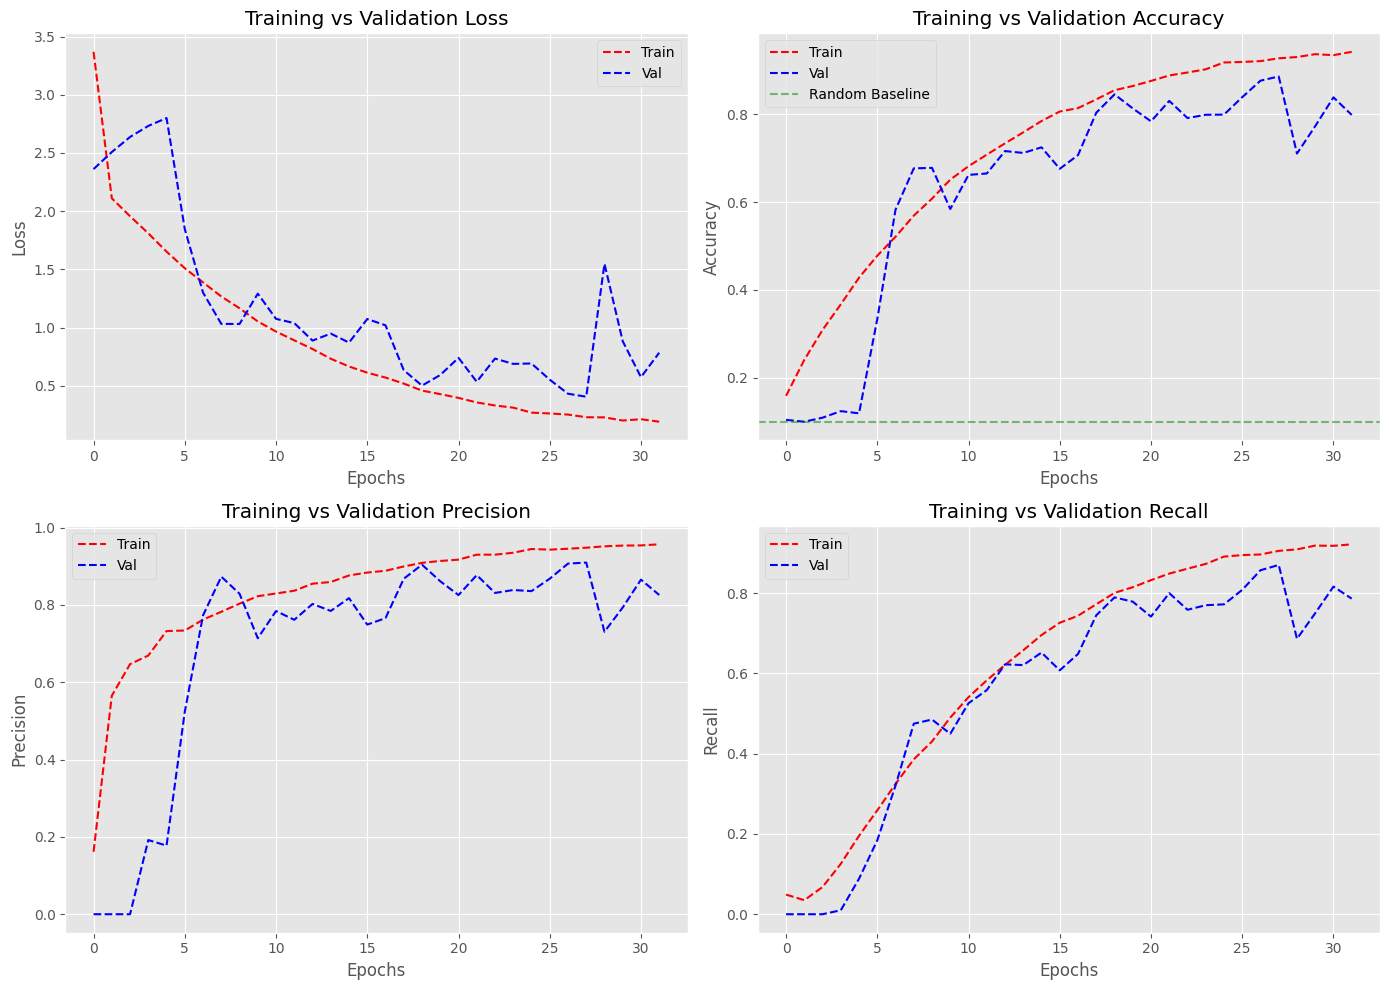

In [ ]:
plot_learning_curve(
    history.history['loss'], history.history['val_loss'],
    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
    history.history['precision'], history.history['val_precision'],
    history.history['recall'], history.history['val_recall'],
    output_classes=10
)

In [ ]:
test = load(dir_test_dataset)
test['label'] = test['label'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=dir_test_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

Found 2844 validated image filenames belonging to 10 classes.


In [ ]:
def visualize_32predictions(
    model: Model,
    test_generator,
    to_file: str = None
) -> None:
    fig, ax = plt.subplots(8, 4, figsize=(20, 20))
    ax = ax.ravel()

    class_labels = list(test_generator.class_indices.keys())
    sample_indices = random.sample(range(len(test_generator.filenames)), 32)

    for i, idx in enumerate(sample_indices):
        img_path = test_generator.filepaths[idx]

        # Load the image manually
        img = image.load_img(img_path, target_size=test_generator.target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # normalize if needed (depends on your ImageDataGenerator)

        # Predict
        pred = model.predict(img_array, verbose=0)

        predicted_index = np.argmax(pred)
        predicted_label = class_labels[predicted_index]

        true_index = test_generator.classes[idx]
        true_label = class_labels[true_index]

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(
            f'Ground Truth: {true_label}\nPrediction: {predicted_label}',
            fontsize=8
        )
        ax[i].text(
            0.5, 1.15, f'{"CORRECT" if predicted_index == true_index else "INCORRECT"}',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax[i].transAxes,
            fontsize=8,
            color='green' if predicted_index == true_index else 'red',
            weight='bold'
        )

    plt.tight_layout()
    plt.show()

    if to_file:
        fig.savefig(to_file, bbox_inches='tight')

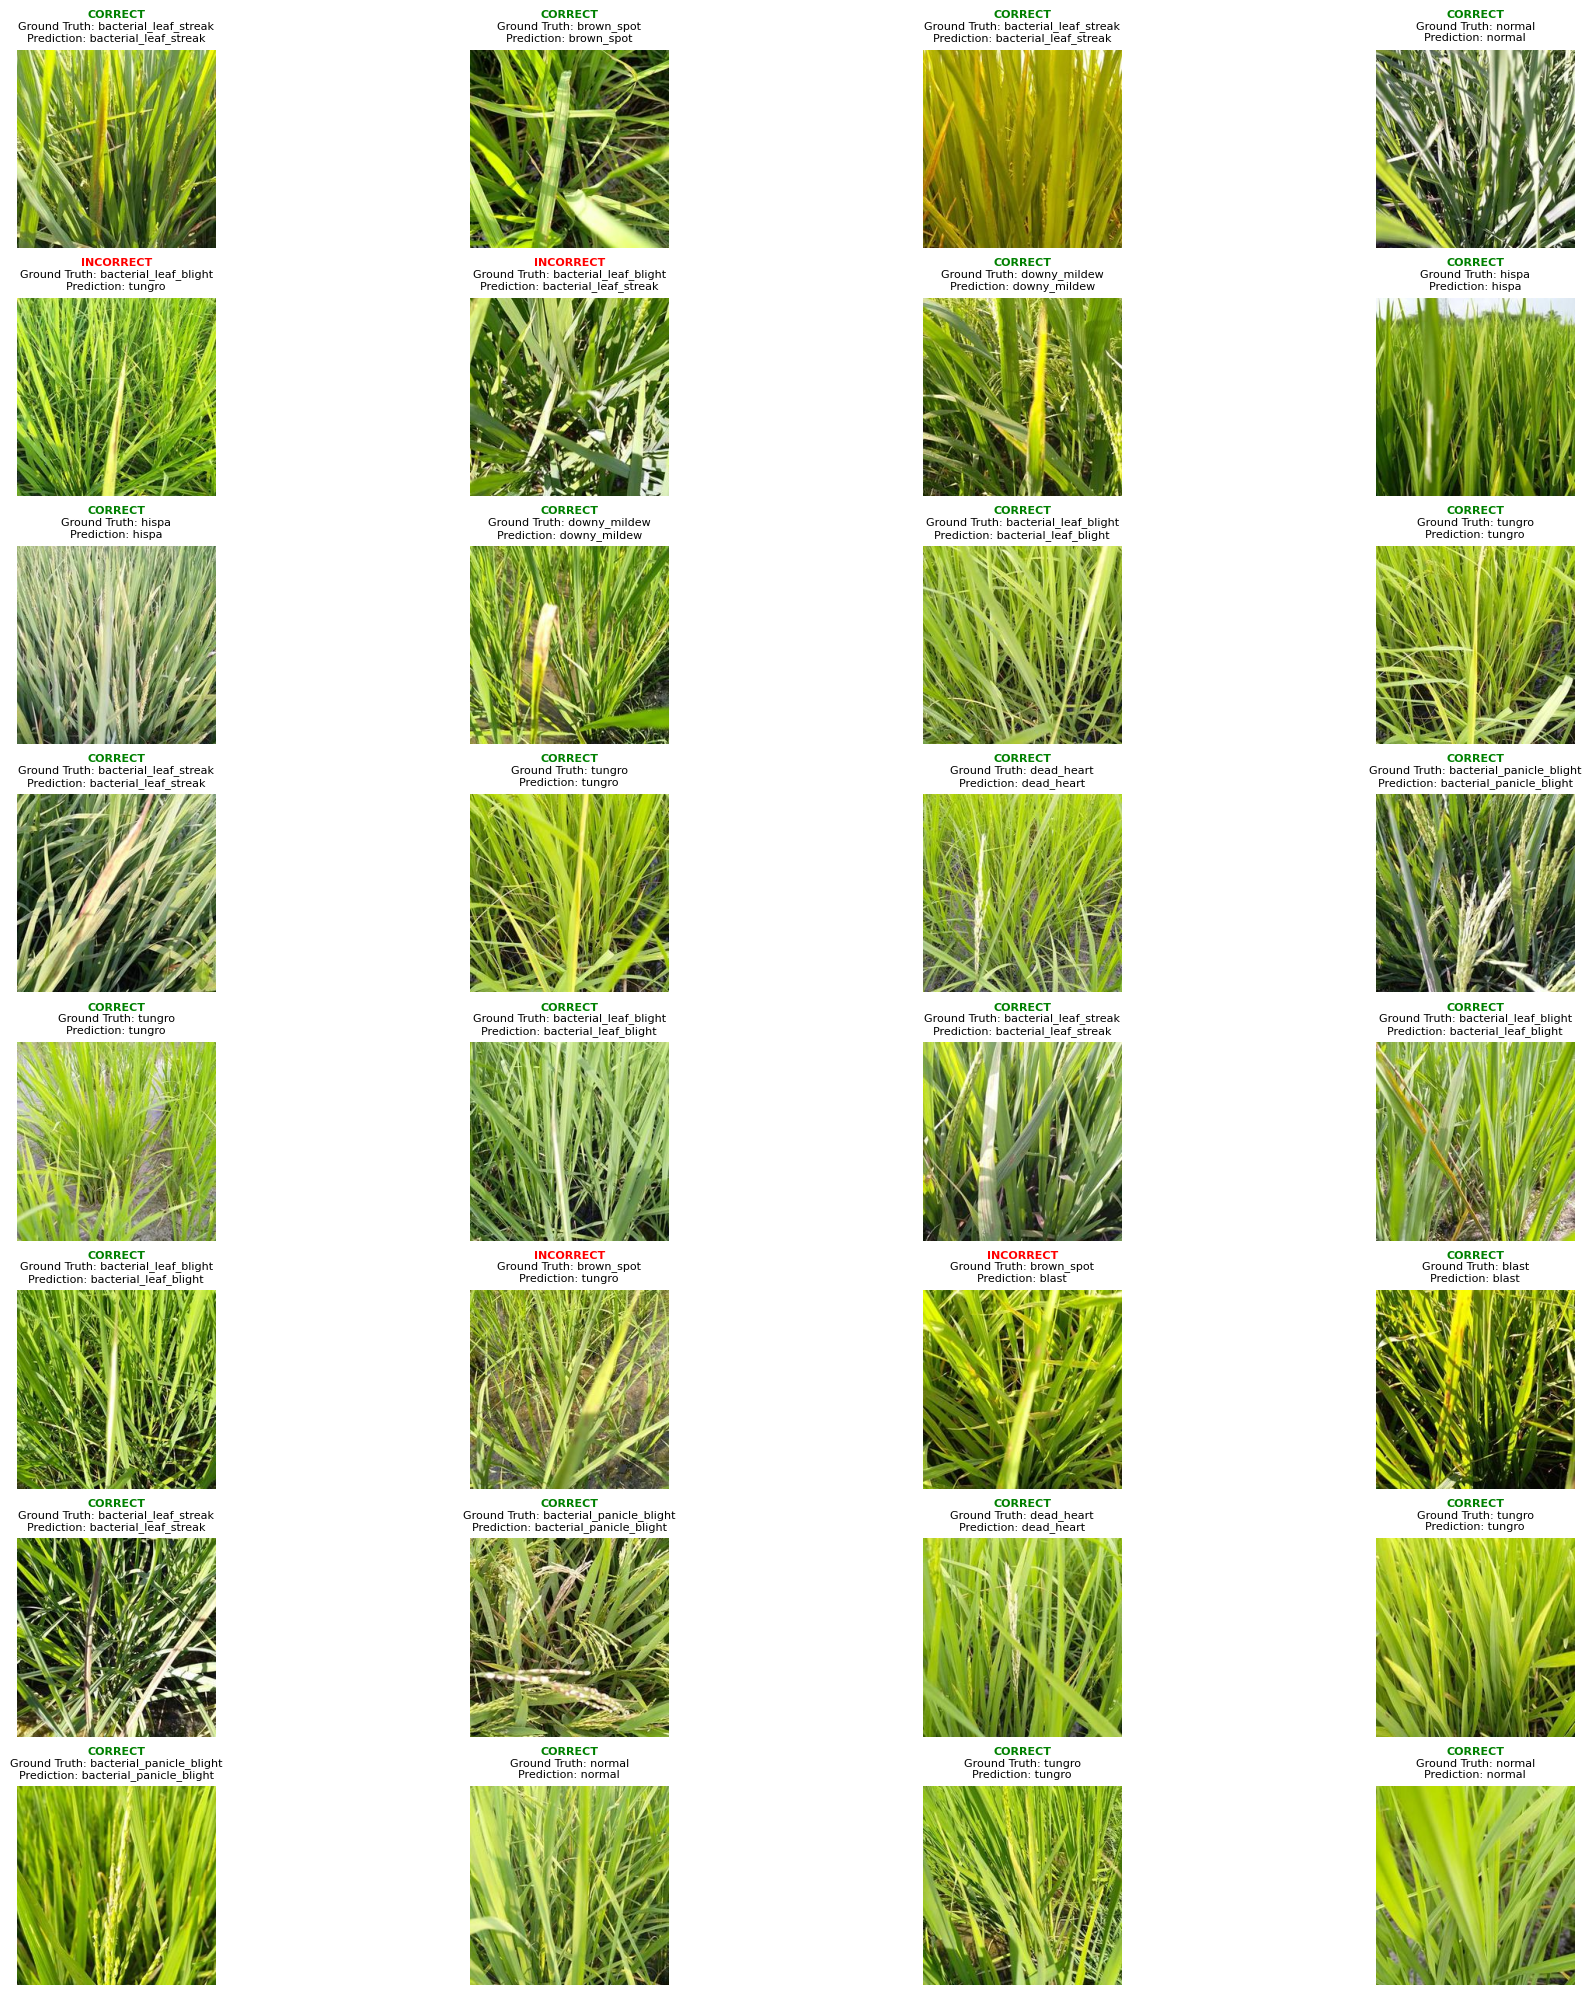

In [ ]:
visualize_32predictions(model, test_generator)

In [ ]:
# Evaluate on training set
train_loss, train_acc, train_precision, train_recall = model.evaluate(train_generator, steps=len(train_generator), verbose=1)
print(f"Train Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}, Precison: {train_precision:.4f}, Recall: {train_recall:.4f}")

# Evaluate on validation set
val_loss, val_acc, val_precision, val_recall = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - categorical_accuracy: 0.9646 - loss: 0.1137 - precision: 0.9716 - recall: 0.9548
Train Accuracy: 0.9641, Loss: 0.1117, Precison: 0.9719, Recall: 0.9556
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - categorical_accuracy: 0.7970 - loss: 0.8165 - precision: 0.8248 - recall: 0.7866
Validation Accuracy: 0.7981, Loss: 0.7838, Precision: 0.8255, Recall: 0.7860


In [ ]:
# Evaluate on testing set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2844/2844 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - categorical_accuracy: 0.8014 - loss: 0.7571 - precision: 0.8269 - recall: 0.7801
Test Accuracy: 0.8115, Loss: 0.6925, Precision: 0.8362, Recall: 0.7915


2844/2844 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step


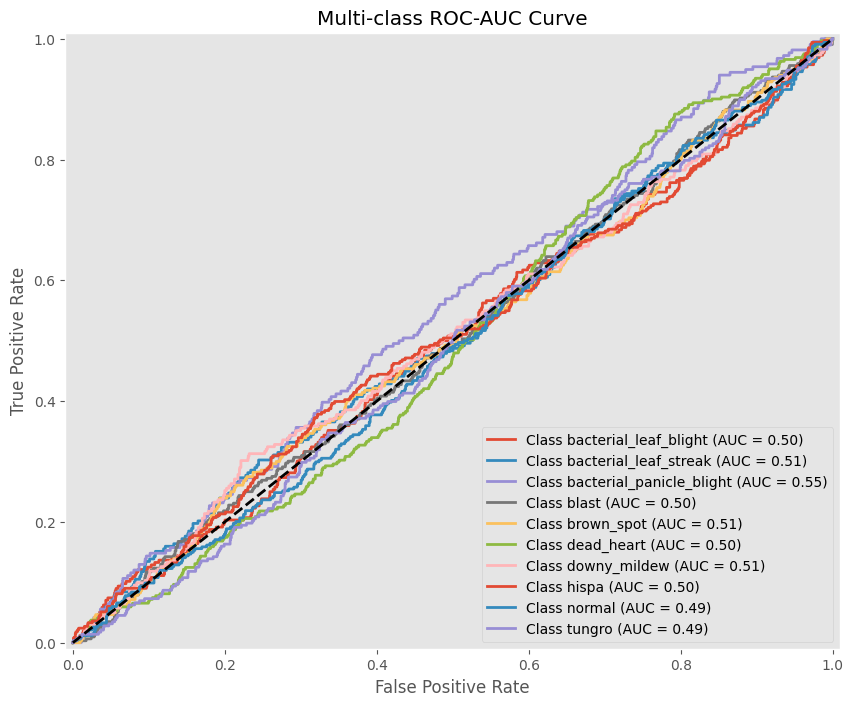

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 1: Get scaled probabilities
temperature = 1.5
logits = model.predict(test_generator, verbose=1)
scaled_probs = tf.nn.softmax(logits / temperature, axis=1).numpy()

# Step 2: Get true labels
true_labels = test_generator.classes
true_labels_one_hot = tf.keras.utils.to_categorical(true_labels, num_classes=OUTPUT_CLASSES)

# Step 3: Compute ROC per class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(OUTPUT_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], scaled_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(OUTPUT_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves after Temperature Scaling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# Step 1: Predict
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Gather true labels
y_true = test_generator.classes
filenames = test_generator.filenames

# Step 3: Map indices back to label names
index_to_label = {v: k for k, v in test_generator.class_indices.items()}
true_labels = [index_to_label[i] for i in y_true]
pred_labels = [index_to_label[i] for i in y_pred]

# Step 4: Create DataFrame
results_df = pd.DataFrame({
    'filename': filenames,
    'true_label': true_labels,
    'predicted_label': pred_labels,
    'correct': [t == p for t, p in zip(true_labels, pred_labels)]
})

# Optional: add confidence score (max predicted prob)
results_df['confidence'] = np.max(y_pred_probs, axis=1)

# View sample results
print(results_df.head())

2844/2844 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
                              filename                true_label  \
0  bacterial_panicle_blight/102078.jpg  bacterial_panicle_blight   
1  bacterial_panicle_blight/107067.jpg  bacterial_panicle_blight   
2  bacterial_panicle_blight/101225.jpg  bacterial_panicle_blight   
3  bacterial_panicle_blight/101592.jpg  bacterial_panicle_blight   
4  bacterial_panicle_blight/107214.jpg  bacterial_panicle_blight   

            predicted_label  correct  confidence  
0                dead_heart    False    0.995732  
1                    normal    False    0.800599  
2     bacterial_leaf_streak    False    0.884231  
3  bacterial_panicle_blight     True    0.999940  
4     bacterial_leaf_streak    False    0.999008  


In [ ]:
results_df.to_csv("test_predictions (2).csv", index=False)